In [1]:
from subprocess import Popen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client as win32

%config InlineBackend.figure_format = 'png'
pd.options.display.max_columns = None

### Константы

In [2]:
MbalPath = "mbal.exe"
InputFilename = "devon.mbi"
UnitSystem = "Norwegian S.I."

### Вспомогательные функции

In [3]:
def GetAppName(strval):
    pos = strval.find(".")
    if pos < 2:
        raise Exception("Badly formed tag string")
    appname = strval[0:pos]
    if appname != "GAP" and appname != "MBAL" and appname != "PROSPER":
        raise Exception("Unrecognised application name in tag string")
    return appname

In [4]:
def DoCmd(server, cmd):
    err = server.DoCommand(cmd)
    if err > 0:
        err = server.GetErrorDescription(err)
        raise Exception(err)

In [5]:
def DoSet(server, varname, val):
    err = server.SetValue(varname, val)
    appname = GetAppName(varname)
    err = server.GetLastError(appname)
    if err > 0:
        err = server.GetErrorDescription(err)
        raise Exception(err)

In [6]:
def DoGet(server, varname):
    val = server.GetValue(varname)
    appname = GetAppName(varname)
    err = server.GetLastError(appname)
    if err > 0:
        err = server.GetErrorDescription(err)
        raise Exception(err)
    return val

### Основной код

In [7]:
proc = Popen(MbalPath)

In [8]:
server = win32.Dispatch("PX32.OpenServer.1")

In [9]:
DoCmd(server, "MBAL.OPENFILE(\"" + InputFilename + "\"")

In [10]:
DoCmd(server, "MBAL.SETUNITSYS(\"" + UnitSystem + "\")")

In [11]:
tankcnt = int(DoGet(server, "MBAL.MB.TRES.COUNT"))
print("Количество танков:", tankcnt)

Количество танков: 3


In [12]:
df_list = {}

In [13]:
for i in range(tankcnt):
    df = pd.DataFrame(columns=["DATE", "GAS"], dtype=str)
    prefix = "MBAL.MB.TRES[{Prediction}][" + str(i+1) + "]"
    name = DoGet(server, prefix + ".NAME")
    rowcnt = int(DoGet(server, prefix + ".COUNT"))
    for j in range(rowcnt):
        date = DoGet(server, prefix + "[" + str(j) + "].TIME")
        gas = DoGet(server, prefix + "[" + str(j) + "].AVEGASTOTAL")
        df = df.append(pd.DataFrame([[date, gas]], columns=["DATE", "GAS"]))
    df["DATE"] = df["DATE"].astype('datetime64[ns]')
    df["GAS"] = df["GAS"].astype('float64')
    df.loc[df["GAS"] > 10000000000, "GAS"] = np.NaN
    df_list[name] = df

In [14]:
server = None

In [15]:
proc.terminate()

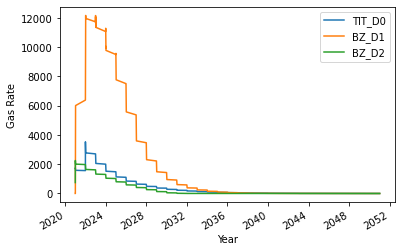

In [16]:
fig, ax = plt.subplots()
for name in df_list:
    df = df_list[name]
    df.plot(x="DATE", y="GAS", label=name, ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Gas Rate")
plt.show()